# Carr and Madan Approach for Option Pricing

We model the asset $S(t)$ using a Merton Jump Diffusion model:
$$
dS(t) = S(t) \left(\mu\, dt + \sigma\, dW(t) + (J - 1)\, dN(t) \right)
$$

The log-return process $ X(t) = \ln S(t) $ is given by:
$$
dX(t) = \left( \mu - \frac{\sigma^2}{2} - \epsilon_J \left(e^{\mu_J + \frac{\sigma_J^2}{2}} - 1 \right) \right) dt + \sigma\, dW(t) + \ln(J)\, dN(t)
$$

### Implementation
- **Evaluation of the log-price characteristic function** under the risk-neutral measure.
- **Use of the Fast Fourier Transform (FFT)** for evaluating the probability density function (PDF).
- **Comparison of the obtained distribution** with a normal distribution having the same mean and variance.


In [7]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.fft import fft, fftshift       

In [23]:
#Put Option Parameters
S0 = 100                            #Underlying asset 
K = np.array([50,100,150])          #Strike price
r = 0.03                            #Risk_free rate
q = 0                               #Dividend_yield
T = 0.5                             #Maturity [half a year]

#Merton Model Parameters
sigma = 0.2353                      #GBM Volatility
lam = 0.2017                        #Poisson coefficent
mu_j = -0.2837                      #Mean value jump rate
sigma_j = 0.1867                    #Volatility jump

#Carr and Madan parameters
alfa = np.array([-0.5,-1,-1.5,-2,-2.5])                         #Carr and Madan tuning for put option
N = 2**12                                                       #Carr adn Madan parameter for integram approximation
nu = 0.50                                                       #Carr adn Madan parameter for integram approximation
l = 2*np.pi/(N*nu)                                              #Spacing of log-strike grid
b = l*N/2                                                       #Boundary values for log-strike grid

#Frequency grid
u = nu * np.arange(N)   

#Log-strike grid
k = -b + (l * np.arange(N)) 

#Weight for numerical integration contributes
nu_j = nu*np.ones(N)                #1 for hedge values
nu_j[0] = 0.5*nu                    #.5 for hedge values
nu_j[-1] = nu_j[0]                  #.5 for hedge values

### Characteristic Function for the Log-Price Process

Under the risk-neutral measure, the characteristic function for the log-price process $ X(t) = \ln S(t) $ of an option can be expressed as:

$$
\varphi(u) = \mathbb{E}\left[e^{iuX(T)}\right] = \exp\left\{ i u \left( \mu - \frac{\sigma^2}{2} - \lambda\left(e^{\mu_J + \frac{\sigma_J^2}{2}} - 1\right) \right) T - \frac{1}{2}\sigma^2 u^2 T + \lambda T \left(e^{i u \mu_J - \frac{1}{2} u^2 \sigma_J^2} - 1\right) \right\}.
$$

In the Carr and Madan approach, a damped version of the characteristic function is used to price European options. This damped characteristic function is given by:

$$
\psi(u) = \frac{e^{-rT}\, \varphi\left(u - (\alpha+1)i\right)}{\alpha^2 + \alpha - u^2 + i(2\alpha+1) u},
$$

where:
- $ r $ is the risk-free rate,
- $ T $ is the time to maturity,
- $ \alpha $ is a damping factor,
- $ \varphi(u) $ is the characteristic function of $ S(T) $,
- $ u $ is the Fourier transform variable.

This formula, implemented in the `psi` function in the code, is crucial for efficiently computing option prices using the Fast Fourier Transform (FFT) in the Carr and Madan framework.


In [24]:
#Characteristic function for general European option
def psi(u, r, T, alfa, phi):
    num = np.exp(-r * T) * phi(u - (alfa + 1) * 1j)
    den = alfa**2 + alfa - u**2 + 1j * (2 * alfa + 1) * u
    return num / den

### Characteristic Function for the Asset Price $S(T)$ under the Merton Jump Diffusion Model

The characteristic function of $S(T)$ in the Merton Jump Diffusion model is given by:

$$
\varphi(u) = \exp \left( i u \ln S_0 + i u \left( r - q - \frac{\sigma^2}{2} - \lambda \left( e^{\mu_J + \frac{\sigma_J^2}{2}} - 1 \right) \right) T - \frac{1}{2} u^2 \sigma^2 T + \lambda T \left( e^{i u \mu_J - \frac{1}{2} u^2 \sigma_J^2} - 1 \right) \right)
$$

Where:
- $ S_0 $: Initial asset price  
- $ r $: Risk-free rate  
- $ q $: Dividend yield  
- $ \sigma $: Volatility of the Brownian motion  
- $ \lambda $: Intensity of the Poisson process (jump frequency)  
- $ \mu_J $: Mean of the logarithm of the jump factor  
- $ \sigma_J $: Standard deviation of the logarithm of the jump factor  
- $ T $: Time horizon  

This characteristic function captures the probability distribution of the asset price $S(T)$, considering both the continuous Brownian motion and discrete Poisson jumps.



In [25]:
#Characteristic function of Merton jump diffusion model 
def phi_merton(u):
    global r,q,T,sigma,lam,mu_j,sigma_j 

    k = np.exp(mu_j + 0.5 * sigma_j**2) - 1
    exponent = (1j * u * (r - q - 0.5 * sigma**2 - lam * k) * T 
               - 0.5 * u**2 * sigma**2 * T 
               + lam * T * (np.exp(1j * u * (mu_j - 0.5 * sigma_j**2) 
               - 0.5 * u**2 * sigma_j**2) - 1))
    return np.exp(exponent)

In [26]:
#Mean and Variance value of Merton Model
k_ = np.exp(mu_j+0.5*sigma_j**2)-1
mu_risk_neutral = (r-q-0.5*sigma**2-lam*k_)*T  
var_risk_neutral = (sigma**2 + lam * (mu_j**2 + sigma_j**2)) * T

x = k

#PDF
pdf_normal = norm.pdf(x, mu_risk_neutral, np.sqrt(var_risk_neutral))

#merton_pdf = fftshift(np.abs(fft(phi_merton(u))))
merton_pdf = np.fft.ifft(phi_merton(u)) * nu * N / (2 * np.pi)
merton_pdf = np.real(np.fft.fftshift(merton_pdf))

#merton_pdf = merton_pdf/max(merton_pdf)
dx = x[1] - x[0]  # Assicurati che x sia la griglia corretta
merton_pdf = merton_pdf / (np.sum(merton_pdf) * dx)

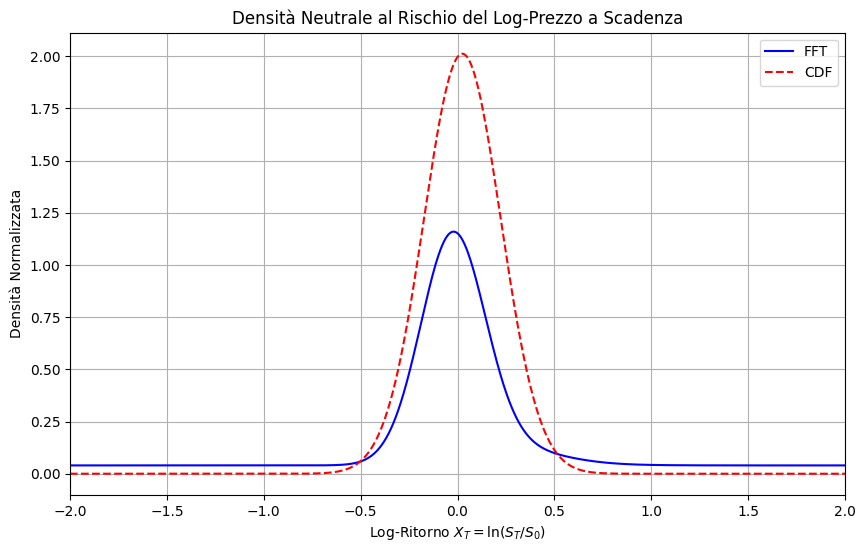

In [28]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, merton_pdf, label='FFT', color='blue')
plt.plot(x, pdf_normal, label='CDF', linestyle='--', color='red')
plt.title("Densità Neutrale al Rischio del Log-Prezzo a Scadenza")
plt.xlabel("Log-Ritorno $X_T = \ln(S_T/S_0)$")
plt.ylabel("Densità Normalizzata")
plt.xlim(-2, 2) 
plt.legend()
plt.grid(True)
plt.show()

## Option Pricing with Fourier Integral and Fast Fourier Transform (FFT)

This code prices options using the **Carr and Madan approach** by applying the **Fast Fourier Transform (FFT)** to efficiently compute the option prices.

### Key Steps:

1. **Fourier Integral Calculation:**
   - The `psi` function computes the characteristic function of the log-price under the risk-neutral measure.
   - For each value of $ u $, `psi_u` stores the result of the characteristic function applied to the Merton jump diffusion model (`phi_merton`).
   - The integrand $ H $ is then computed as:

$$
H = \psi_u \cdot \nu_j \cdot e^{i b u}
$$

2. **Fast Fourier Transform (FFT):**
   - The `fft` function applies the FFT to the integrand $ H $, producing the transformed values `hn`.
   - Finally, the put option prices are extracted from the real part of the FFT result, properly scaled:

$$
\text{put\_prices} = \frac{\text{hn.real}}{\pi} \cdot e^{-\alpha k} \cdot e^{-r T}
$$

### Mathematical Explanation
$$
C(k) = e^{rT} \frac{e^{-\alpha k}}{\pi} \int_{0}^{+\infty} e^{-iuk}\psi(u) \, du
$$

$$
I(k) \equiv \int_{0}^{+\infty} e^{-iuk}\psi(u) \, du \approx \sum_{j=0}^{N-1} e^{-iu_jk}\psi(u_j) \, w_j
$$

with:
- $u_j = \eta j$ (discretization step $\eta$)
- $w_j$ = Simpson weights

$$
H_j = e^{ibu_j} \psi(u_j) w_j
$$

$$
h_n = \text{FFT}(H_j) = \sum_{j=0}^{N-1} e^{-i2\pi jn/N} H_j
$$

$$
C(k_n) = \frac{e^{-\alpha k_n} e^{-rT}}{\pi} \, h_n
$$

$$
C(k) = e^{rT} \frac{e^{-\alpha k}}{\pi} \underbrace{\int_{0}^{+\infty} e^{-iuk}\psi(u) \, du}_{\text{Discretizzato}} \Rightarrow C(k_n) = \frac{e^{-\alpha k_n} e^{-rT}}{\pi} \underbrace{\text{FFT}\left[e^{ibu_j}\psi(u_j)w_j\right]}_{h_n}
$$

This method efficiently computes option prices by leveraging FFT, making the evaluation of complex integrals faster and more accurate.

In [ ]:
#Option Pricing

#Fourier Integral
psi_u = []
for i in u:
    psi_u.append(psi(i, r, T, alfa, phi_merton))
psi_u = np.array(psi_u)
H = psi_u*nu_j*np.exp(1j*b*u)

#Fast Fourier 
hn = fft(H)
put_prices = (hn.real / (np.pi)) * np.exp(-alfa*k)*np.exp(-r*T)

In [ ]:
#Strike grid 
K_log = np.log(K[:]/S0)
indices = np.argmin(np.abs(k - K_log[:, None]), axis=1)
print("Prezzi Put:", S0*put_prices[indices])

In [ ]:
K_space = np.arange(25,185,5)
K_spacelog = np.log(K_space/S0)
indices_space = np.argmin(np.abs(k - K_spacelog[:, None]), axis=1)
strikes = K_space

### Merton Jump Diffusion Option Pricing Code Explanation

This Python code calculates **option prices** under the Merton Jump Diffusion model, which extends the Black-Scholes framework to account for asset price jumps.

In [ ]:
def d1(S,K,r,T,sigma):
    return (np.log(S/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
def d2(S,K,r,T,sigma):
    return (np.log(S/K)+(r-sigma**2/2)*T)/(sigma*np.sqrt(T))

def black_scholes_price(S, K, r, T, sigma, flagCP):
    # Standard Black-Scholes formula
    if flagCP == 1:  # Call option
        return S * norm.cdf(d1(S, K, r, T, sigma)) - K * np.exp(-r * T) * norm.cdf(d2(S, K, r, T, sigma))
    elif flagCP == -1:  # Put option
        return K * np.exp(-r * T) * norm.cdf(-d2(S, K, r, T, sigma)) - S * norm.cdf(-d1(S, K, r, T, sigma))
    
def merton_jump_diffusion(S0, K, r, T, sigma, lambd, muJ, sigmaJ, flagCP, N = 100):
    # Merton Jump Diffusion Option Pricing
    jump_price = 0.0
    for n in range(N):
        # Adjust rate for jumps
        
        r_n = r - lambd * (np.exp(muJ + 0.5 * sigmaJ ** 2) - 1) + n * muJ / T
        sigma_n = np.sqrt(sigma ** 2 + n * sigmaJ ** 2 / T)
        # Poisson probability
        poisson_prob = np.exp(-lambd * T) * (lambd * T) ** n / mt.factorial(n)
        # Add Black-Scholes price for n jumps
        jump_price += poisson_prob * black_scholes_price(S0, K, r_n, T, sigma_n, flagCP)
    return jump_price

prezzo_mjd = []
for K in strikes:
    prezzo_mjd.append(merton_jump_diffusion(S0, K, r, T, sigma, lam, mu_j, sigma_j, flagCP=-1))

prezzo_mjd = np.array(prezzo_mjd)

In [ ]:
#Plot Put_price
plt.figure(figsize=(10, 6))
plt.plot(strikes, S0*put_prices[indices_space], label='Put_price Carr and Madan', color='blue')
plt.plot(strikes, prezzo_mjd, label='Put_price B&S', color='red')
plt.title("Put-price variability for Strikes")
plt.xlabel("Strikes")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()